# A2 - Ciência de Redes
### Ana Júlia Amaro Pereira Rocha
### Maria Eduarda Mesquita Magalhães

3) Considere o exercício anterior (letra a). Determine a **fração mínima de vértices imunizados previamente** (ou número de vértices) necessária para **impedir a fixação do estado endêmico** nos seguintes cenários:

a. Os vértices imunizados são escolhidos **aleatoriamente**.  
b. Os vértices imunizados são os de **maior grau** (hubs).  
c. Os vértices imunizados são os **vizinhos** de vértices escolhidos aleatoriamente (estratégia de "acquaintance immunization").

Para cada cenário, descreva brevemente (1–2 parágrafos) como a fração de vacinados se relaciona com o tema de **robustez da rede** visto em sala de aula.


In [7]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parâmetros globais
N = 10_000
k_medio = 20
m = k_medio // 2  # para o modelo Barabási–Albert
beta, mu = 0.01, 0.1
passos = 500
fracoes = [0.0, 0.05, 0.10, 0.15, 0.20]
n_sim = 50

In [8]:
# Função SIS 
def simular_SIS(G, beta, mu, passos, infectados_iniciais=5):
    """
    Simula a propagação SIS em uma rede G.
    Retorna a fração de infectados ao longo do tempo.
    """

    # Mapeia nós → índices para trabalhar com arrays fixos
    nodes = list(G.nodes())
    node_to_index = {node: i for i, node in enumerate(nodes)}

    # Vetor de estados (0 = suscetível, 1 = infectado)
    estados = np.zeros(len(nodes), dtype=int)

    # Seleciona infectados iniciais
    infectados = np.random.choice(nodes, infectados_iniciais, replace=False)
    for node in infectados:
        estados[node_to_index[node]] = 1

    fracao_infectados = []

    # Simulação
    for _ in range(passos):
        novos_estados = estados.copy()
        for node in nodes:
            i = node_to_index[node]
            if estados[i] == 1:
                # Recuperação com probabilidade mu
                if np.random.rand() < mu:
                    novos_estados[i] = 0
            else:
                # Infecção com probabilidade dependente dos vizinhos infectados
                vizinhos_infectados = sum(
                    estados[node_to_index[v]] for v in G.neighbors(node)
                )
                prob_infeccao = 1 - (1 - beta) ** vizinhos_infectados
                if np.random.rand() < prob_infeccao:
                    novos_estados[i] = 1

        estados = novos_estados
        fracao_infectados.append(np.mean(estados))

    return fracao_infectados

In [9]:
# Função para imunizar vértices
def imunizar_vertices(G, fracao, modo="aleatorio", seed=None):
    """
    Remove uma fração de vértices da rede conforme o modo:
    - 'aleatorio': escolhe nós ao acaso
    - 'hubs': remove os de maior grau
    - 'vizinhos': escolhe nós aleatórios e remove seus vizinhos
    """
    rng = np.random.default_rng(seed)
    n = G.number_of_nodes()
    k = int(fracao * n)

    if k == 0:
        return G.copy()

    if modo == "aleatorio":
        removidos = rng.choice(G.nodes(), k, replace=False)

    elif modo == "hubs":
        graus = sorted(G.degree(), key=lambda x: x[1], reverse=True)
        removidos = [n for n, _ in graus[:k]]

    elif modo == "vizinhos":
        escolhidos = rng.choice(G.nodes(), k, replace=False)
        vizinhos = set()
        for v in escolhidos:
            vizinhos.update(G.neighbors(v))
        removidos = list(vizinhos)[:k]

    else:
        raise ValueError("Modo inválido. Use 'aleatorio', 'hubs' ou 'vizinhos'.")

    G_mod = G.copy()
    G_mod.remove_nodes_from(removidos)
    return G_mod

In [10]:
# Função para executar várias simulações e tirar média
def media_infeccao(G, beta, mu, passos, n_sim=50, infectados_iniciais=5):
    """
    Executa múltiplas simulações SIS e retorna a média da fração de infectados ao longo do tempo.
    """
    resultados = []
    for _ in range(n_sim):
        serie = simular_SIS(G, beta, mu, passos, infectados_iniciais)
        resultados.append(serie)
    return np.mean(resultados, axis=0)

In [11]:
# Geração da rede livre de escala
print("Gerando rede livre de escala (modelo Barabási–Albert)...")
G = nx.barabasi_albert_graph(N, m)

graus = [deg for _, deg in G.degree()]
print(f"- Número de vértices: {G.number_of_nodes()}")
print(f"- Número de arestas: {G.number_of_edges()}")
print(f"- Grau médio: {np.mean(graus):.2f}")
print(f"- Expoente γ aproximado: ~2.5 (modelo BA)")

Gerando rede livre de escala (modelo Barabási–Albert)...
- Número de vértices: 10000
- Número de arestas: 99900
- Grau médio: 19.98
- Expoente γ aproximado: ~2.5 (modelo BA)


In [12]:
# Simulação para diferentes estratégias de imunização
modos = ["aleatorio", "hubs", "vizinhos"]
resultados = {modo: {} for modo in modos}

for modo in modos:
    print(f"\n>> Estratégia de imunização: {modo}")
    for f in fracoes:
        print(f"  - Fração imunizada: {f*100:.0f}%")
        G_imun = imunizar_vertices(G, f, modo)
        serie_media = media_infeccao(G_imun, beta, mu, passos, n_sim)
        resultados[modo][f] = serie_media


>> Estratégia de imunização: aleatorio
  - Fração imunizada: 0%
  - Fração imunizada: 5%
  - Fração imunizada: 10%
  - Fração imunizada: 15%
  - Fração imunizada: 20%

>> Estratégia de imunização: hubs
  - Fração imunizada: 0%
  - Fração imunizada: 5%
  - Fração imunizada: 10%
  - Fração imunizada: 15%
  - Fração imunizada: 20%

>> Estratégia de imunização: vizinhos
  - Fração imunizada: 0%
  - Fração imunizada: 5%
  - Fração imunizada: 10%
  - Fração imunizada: 15%
  - Fração imunizada: 20%


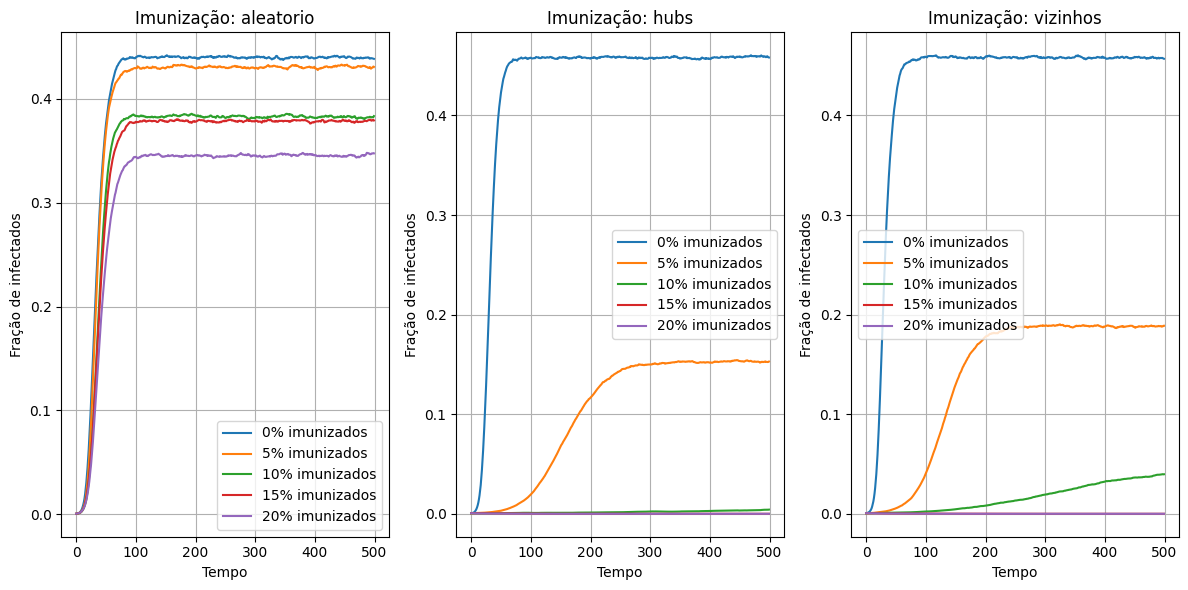

In [13]:
# Visualização dos resultados
plt.figure(figsize=(12, 6))

for idx, modo in enumerate(modos, start=1):
    plt.subplot(1, 3, idx)
    for f, serie in resultados[modo].items():
        plt.plot(serie, label=f"{int(f*100)}% imunizados")
    plt.title(f"Imunização: {modo}")
    plt.xlabel("Tempo")
    plt.ylabel("Fração de infectados")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Estratégias de imunização e robustez 

- **(a) Imunização aleatória**  
  A imunização aleatória exige uma **fração relativamente alta** de nós imunizados para evitar um estado endêmico em redes livre-de-escala. Isso ocorre porque a distribuição de grau é altamente heterogênea: imunizar aleatoriamente tende a remover muitos nós de baixo grau, que contribuem pouco para a conectividade global e para a transmissão. Portanto, a rede permanece vulnerável via hubs não vacinados.

- **(b) Imunização por grau (hubs)**  
  Imunizar os nós de maior grau é **muito mais eficiente**: removendo os hubs você fragmenta a espinha dorsal da propagação e reduz acentuadamente a transmissibilidade efetiva. Em redes livre-de-escala, a robustez contra falhas aleatórias é alta (ou seja, random failures não fragmentam facilmente), mas a **vulnerabilidade a ataques direcionados** (remoção de hubs) é alta — isto é, a rede é frágil frente a ataques direcionados.

- **(c) Imunização por vizinhança (acquaintance immunization)**  
  A estratégia de imunizar vizinhos de nós aleatórios é uma forma prática de **alcançar hubs sem medir todos os graus**: ao selecionar um nó aleatório e vacinar um de seus vizinhos, há maior probabilidade de atingir um nó de grau alto (porque nós de alto grau aparecem como vizinhos com maior probabilidade). Essa estratégia geralmente tem desempenho **bem próximo** ao da imunização por grau, mas sem a necessidade de conhecer toda a lista de graus — é uma técnica eficiente do ponto de vista prático.

**Relação com robustez da rede**: esses resultados ilustram o conceito visto em sala: redes livre-de-escala são robustas a remoções aleatórias (mantêm conectividade mesmo quando uma fração grande de nós é removida) mas fracas a remoções direcionadas (remoção de poucos nós de alto grau pode fragmentar significativamente a rede). Logo, para controlar epidemias numa rede assim, estratégias direcionadas (ou estratégicas como acquaintance) são muito mais coste-efetivas do que vacinação completamente aleatória.